In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


### Select Device ( GPU or CPU)
we will select device. there are two options: GPU or CPU. GPU technology is so faster than CPU technology. We will select GPU device. If your System is not include GPU technology, our function select CPU device.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


###   Create Directory 

In [4]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Hyper Parameters

In [24]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

### Define Dataset

In [6]:
dataset = torchvision.datasets.MNIST(root='../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

###  Data Loader

In [7]:
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

### Visualization Dataset

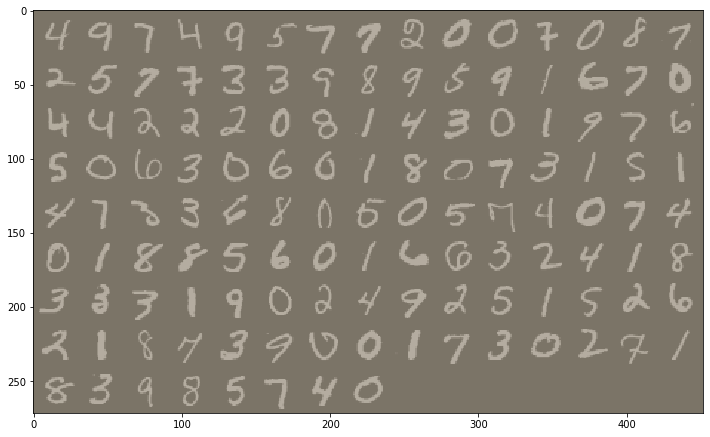

In [10]:
for images, labels in data_loader:
    break
im = make_grid(images,nrow=15)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,24))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

### Build Network

In [21]:
class AutoEncoder( nn.Module):
    
    def __init__(self, image_size =784, h_dim = 400, z_dim = 20):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = F.relu( self.fc4(z))
        return F.sigmoid(self.fc5(h))
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    
model =  AutoEncoder().to(device)


### Optimizer

In [23]:
optimizer =  torch.optim.Adam(model.parameters(), lr = learning_rate)


### Training

In [25]:
for epoch in range(num_epochs):
    for i , (x, _ ) in enumerate(data_loader):
        
        x =  x.to(device).view(-1, image_size)
        x_reconst, mu, log_var  = model(x)
        
        reconst_loss = F.binary_cross_entropy( x_reconst, x, size_average= False)
        
        kl_div =  - 0.5 * torch.sum( 1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = reconst_loss + kl_div
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
            
    with torch.no_grad():
        
        z = torch.randn(batch_size, z_dim).to(device)
        
        out = model.decode(z).view( -1, 1, 28, 28 )
        
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format( epoch+1 )))
        
        out, _, _ = model(x)
        
        x_concat = torch.cat([x.view( -1, 1, 28, 28 ), out.view( -1, 1, 28, 28)], dim = 3 )
        
        save_image( x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10], Step [10/469], Reconst Loss: 35398.1406, KL Div: 4414.6260
Epoch[1/10], Step [20/469], Reconst Loss: 30199.4492, KL Div: 1064.7083
Epoch[1/10], Step [30/469], Reconst Loss: 26260.9082, KL Div: 1412.8466
Epoch[1/10], Step [40/469], Reconst Loss: 27635.1680, KL Div: 583.0892
Epoch[1/10], Step [50/469], Reconst Loss: 26317.1465, KL Div: 845.1511
Epoch[1/10], Step [60/469], Reconst Loss: 26731.2148, KL Div: 797.9926
Epoch[1/10], Step [70/469], Reconst Loss: 24868.2852, KL Div: 919.1700
Epoch[1/10], Step [80/469], Reconst Loss: 22406.9551, KL Div: 1059.1057
Epoch[1/10], Step [90/469], Reconst Loss: 24224.4062, KL Div: 1102.3668
Epoch[1/10], Step [100/469], Reconst Loss: 21367.8770, KL Div: 1346.6943
Epoch[1/10], Step [110/469], Reconst Loss: 21345.8828, KL Div: 1601.2363
Epoch[1/10], Step [120/469], Reconst Loss: 20370.3418, KL Div: 1708.4978
Epoch[1/10], Step [130/469], Reconst Loss: 19958.7441, KL Div: 1610.1912
Epoch[1/10], Step [140/469], Reconst Loss: 19591.7480, KL Div: 1

Epoch[3/10], Step [220/469], Reconst Loss: 11588.5352, KL Div: 3007.7095
Epoch[3/10], Step [230/469], Reconst Loss: 11580.3594, KL Div: 3065.5356
Epoch[3/10], Step [240/469], Reconst Loss: 11921.0000, KL Div: 3065.6924
Epoch[3/10], Step [250/469], Reconst Loss: 11247.4277, KL Div: 3072.5569
Epoch[3/10], Step [260/469], Reconst Loss: 11479.5527, KL Div: 3046.7058
Epoch[3/10], Step [270/469], Reconst Loss: 11165.8359, KL Div: 3008.8940
Epoch[3/10], Step [280/469], Reconst Loss: 11661.9678, KL Div: 3162.6816
Epoch[3/10], Step [290/469], Reconst Loss: 11946.1719, KL Div: 3146.4895
Epoch[3/10], Step [300/469], Reconst Loss: 11444.1914, KL Div: 3013.8701
Epoch[3/10], Step [310/469], Reconst Loss: 11910.6738, KL Div: 3005.8003
Epoch[3/10], Step [320/469], Reconst Loss: 11271.1797, KL Div: 3077.5291
Epoch[3/10], Step [330/469], Reconst Loss: 11520.7207, KL Div: 3086.1597
Epoch[3/10], Step [340/469], Reconst Loss: 11139.1328, KL Div: 3097.2446
Epoch[3/10], Step [350/469], Reconst Loss: 11196.96

Epoch[5/10], Step [430/469], Reconst Loss: 10726.8770, KL Div: 3185.0664
Epoch[5/10], Step [440/469], Reconst Loss: 10861.8965, KL Div: 3160.1262
Epoch[5/10], Step [450/469], Reconst Loss: 10735.7354, KL Div: 3113.6226
Epoch[5/10], Step [460/469], Reconst Loss: 10789.7256, KL Div: 3206.3149
Epoch[6/10], Step [10/469], Reconst Loss: 10740.8994, KL Div: 3127.4045
Epoch[6/10], Step [20/469], Reconst Loss: 10442.0137, KL Div: 3175.3984
Epoch[6/10], Step [30/469], Reconst Loss: 10652.4648, KL Div: 3211.1853
Epoch[6/10], Step [40/469], Reconst Loss: 10806.1973, KL Div: 3134.5513
Epoch[6/10], Step [50/469], Reconst Loss: 10286.8125, KL Div: 3171.6982
Epoch[6/10], Step [60/469], Reconst Loss: 10030.7246, KL Div: 3109.7944
Epoch[6/10], Step [70/469], Reconst Loss: 10331.4199, KL Div: 3241.5769
Epoch[6/10], Step [80/469], Reconst Loss: 11430.1865, KL Div: 3187.2319
Epoch[6/10], Step [90/469], Reconst Loss: 10534.2236, KL Div: 3026.1890
Epoch[6/10], Step [100/469], Reconst Loss: 10537.5127, KL Di

Epoch[8/10], Step [180/469], Reconst Loss: 10455.7207, KL Div: 3199.8013
Epoch[8/10], Step [190/469], Reconst Loss: 10917.1660, KL Div: 3255.1704
Epoch[8/10], Step [200/469], Reconst Loss: 10494.9688, KL Div: 3153.3940
Epoch[8/10], Step [210/469], Reconst Loss: 10304.6172, KL Div: 3247.2002
Epoch[8/10], Step [220/469], Reconst Loss: 10347.9805, KL Div: 3317.7151
Epoch[8/10], Step [230/469], Reconst Loss: 10513.9502, KL Div: 3188.6692
Epoch[8/10], Step [240/469], Reconst Loss: 10825.7695, KL Div: 3314.5142
Epoch[8/10], Step [250/469], Reconst Loss: 10758.4238, KL Div: 3161.0674
Epoch[8/10], Step [260/469], Reconst Loss: 10224.5527, KL Div: 3184.6016
Epoch[8/10], Step [270/469], Reconst Loss: 10408.4678, KL Div: 3166.6946
Epoch[8/10], Step [280/469], Reconst Loss: 10412.2461, KL Div: 3121.8835
Epoch[8/10], Step [290/469], Reconst Loss: 10674.8867, KL Div: 3309.4341
Epoch[8/10], Step [300/469], Reconst Loss: 10016.0488, KL Div: 3215.2539
Epoch[8/10], Step [310/469], Reconst Loss: 10606.99

Epoch[10/10], Step [390/469], Reconst Loss: 10722.5020, KL Div: 3253.5264
Epoch[10/10], Step [400/469], Reconst Loss: 10868.5068, KL Div: 3352.2908
Epoch[10/10], Step [410/469], Reconst Loss: 10410.9238, KL Div: 3243.5220
Epoch[10/10], Step [420/469], Reconst Loss: 10491.9785, KL Div: 3241.3455
Epoch[10/10], Step [430/469], Reconst Loss: 10257.6201, KL Div: 3245.4702
Epoch[10/10], Step [440/469], Reconst Loss: 10761.3076, KL Div: 3274.9873
Epoch[10/10], Step [450/469], Reconst Loss: 10147.7256, KL Div: 3211.2075
Epoch[10/10], Step [460/469], Reconst Loss: 10351.2246, KL Div: 3234.5234


### Save Model 

In [26]:
torch.save(model.state_dict(), 'model.ckpt')


### Visualization Result